In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
num_sample = mnist.train.num_examples
input_dim = mnist.train.images[0].shape[0]
w = h = 28

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
class VariantionalAutoencoder(object):

    def __init__(self, learning_rate=1e-3, batch_size=100, n_z=10):
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_z = n_z

        self.build()

        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, input_dim])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 512, scope='enc_fc1', activation_fn=tf.nn.elu)
        f2 = fc(f1, 384, scope='enc_fc2', activation_fn=tf.nn.elu)
        f3 = fc(f2, 256, scope='enc_fc3', activation_fn=tf.nn.elu)
        self.z_mu = fc(f3, self.n_z, scope='enc_fc4_mu', activation_fn=None)
        self.z_log_sigma_sq = fc(f3, self.n_z, scope='enc_fc4_sigma', activation_fn=None)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=1, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 256, scope='dec_fc1', activation_fn=tf.nn.elu)
        g2 = fc(g1, 384, scope='dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(g2, 512, scope='dec_fc3', activation_fn=tf.nn.elu)
        self.x_hat = fc(g3, input_dim, scope='dec_fc4', activation_fn=tf.sigmoid)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat), 
            axis=1
        )
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = tf.reduce_mean(recon_loss + latent_loss)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, loss, recon_loss, latent_loss = self.sess.run(
            [self.train_op, self.total_loss, self.recon_loss, self.latent_loss],
            feed_dict={self.x: x}
        )
        return loss, recon_loss, latent_loss

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat
    
    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z

In [4]:
def trainer(learning_rate=1e-3, batch_size=100, num_epoch=75, n_z=10):
    model = VariantionalAutoencoder(learning_rate=learning_rate,
                                    batch_size=batch_size, n_z=n_z)

    for epoch in range(num_epoch):
        for iter in range(num_sample // batch_size):
            # Obtina a batch
            batch = mnist.train.next_batch(batch_size)
            # Execute the forward and the backward pass and report computed losses
            loss, recon_loss, latent_loss = model.run_single_step(batch[0])
        
        if epoch % 5 == 0:
            print('[Epoch {}] Loss: {}, Recon loss: {}, Latent loss: {}'.format(
                epoch, loss, recon_loss, latent_loss))
            
    print('Done!')
    return model

In [5]:
# Train the model
model = trainer(learning_rate=1e-4,  batch_size=100, num_epoch=100, n_z=5)

[Epoch 0] Loss: 162.7650146484375, Recon loss: 153.13348388671875, Latent loss: 9.631543159484863
[Epoch 5] Loss: 134.0910186767578, Recon loss: 123.45518493652344, Latent loss: 10.635812759399414
[Epoch 10] Loss: 126.73985290527344, Recon loss: 116.07246398925781, Latent loss: 10.66739273071289
[Epoch 15] Loss: 125.1268539428711, Recon loss: 114.19738006591797, Latent loss: 10.92947006225586
[Epoch 20] Loss: 121.77294158935547, Recon loss: 110.43827056884766, Latent loss: 11.334677696228027
[Epoch 25] Loss: 118.14449310302734, Recon loss: 106.67109680175781, Latent loss: 11.473384857177734
[Epoch 30] Loss: 119.36380767822266, Recon loss: 107.81671905517578, Latent loss: 11.547089576721191
[Epoch 35] Loss: 120.40512084960938, Recon loss: 108.61946105957031, Latent loss: 11.785660743713379
[Epoch 40] Loss: 124.8724594116211, Recon loss: 112.93008422851562, Latent loss: 11.942386627197266
[Epoch 45] Loss: 125.17452239990234, Recon loss: 113.14947509765625, Latent loss: 12.025042533874512

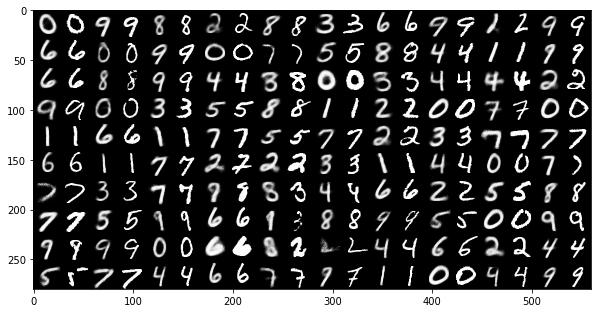

In [6]:
# Test the trained model: reconstruction
batch = mnist.test.next_batch(100)
x_reconstructed = model.reconstructor(batch[0])

n = np.sqrt(model.batch_size).astype(np.int32)
I_reconstructed = np.empty((h*n, 2*w*n))
for i in range(n):
    for j in range(n):
        x = np.concatenate(
            (x_reconstructed[i*n+j, :].reshape(h, w), 
             batch[0][i*n+j, :].reshape(h, w)),
            axis=1
        )
        I_reconstructed[i*h:(i+1)*h, j*2*w:(j+1)*2*w] = x

plt.figure(figsize=(10, 20))
plt.imshow(I_reconstructed, cmap='gray')

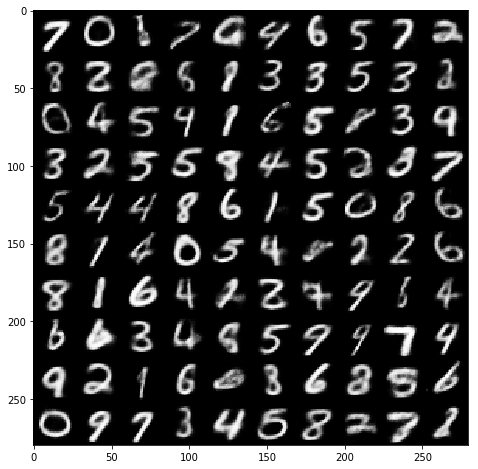

In [7]:
# Test the trained model: generation
# Sample noise vectors from N(0, 1)
z = np.random.normal(size=[model.batch_size, model.n_z])
x_generated = model.generator(z)

n = np.sqrt(model.batch_size).astype(np.int32)
I_generated = np.empty((h*n, w*n))
for i in range(n):
    for j in range(n):
        I_generated[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i*n+j, :].reshape(28, 28)

plt.figure(figsize=(8, 8))
plt.imshow(I_generated, cmap='gray')

In [12]:
batch = mnist.test.next_batch(3000)
z = model.transformer(batch[0])

In [19]:
z[1, :]

1.459383

In [20]:
def linspace5D(point1,point2,length):
    v1 = np.linspace(point1[0],point2[0],length)
    v2 = np.linspace(point1[1],point2[1],length)
    v3 = np.linspace(point1[2],point2[2],length)
    v4 = np.linspace(point1[3],point2[3],length)
    v5 = np.linspace(point1[4],point2[4],length)
    line = np.zeros(shape=[length,5])
    line[:,0]=v1
    line[:,1]=v2
    line[:,2]=v3
    line[:,3]=v4
    line[:,4]=v5
    return line

In [21]:
digit_labels = np.argmax(batch[1], 1)

def same_digit_interpolation(n_cols = 9, z = z, digit_labels = digit_labels):
    same_digit = np.empty((10*28, n_cols*28))
    for d in range(10):
        d_ind = np.where(digit_labels == d)[0]
        (n0, n1) = np.random.choice(d_ind, 2)
        z0 = z[n0, :]
        z1 = z[n1, :]
        zs = linspace5D(z0,z1,n_cols)
        for j in range(len(zs)):
            x_hat = model.generator(z)
            same_digit[d*28:(d+1)*28,j*28:(j+1)*28] = x_hat[0].reshape(28,28)
        
    plt.figure(figsize=(8, 8))
    plt.imshow(same_digit, cmap='gray')

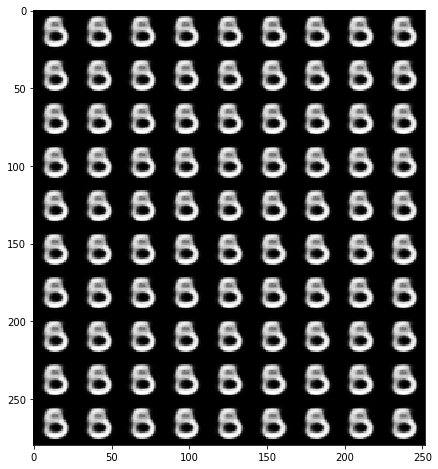

In [22]:
same_digit_interpolation()

In [23]:
tf.reset_default_graph()
# Train the model with 2d latent space
model_2d = trainer(learning_rate=1e-4,  batch_size=100, num_epoch=55, n_z=2)

C:\WINDOWS\system32\venv\lib\site-packages\tensorflow\python\client\session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


[Epoch 0] Loss: 187.5907745361328, Recon loss: 182.5415496826172, Latent loss: 5.049253463745117
[Epoch 5] Loss: 168.6093292236328, Recon loss: 163.7100372314453, Latent loss: 4.899298191070557
[Epoch 10] Loss: 162.40460205078125, Recon loss: 156.86341857910156, Latent loss: 5.541192054748535
[Epoch 15] Loss: 154.05242919921875, Recon loss: 148.5272216796875, Latent loss: 5.5252180099487305
[Epoch 20] Loss: 154.6938934326172, Recon loss: 148.72206115722656, Latent loss: 5.971841335296631
[Epoch 25] Loss: 149.59544372558594, Recon loss: 143.63015747070312, Latent loss: 5.965281963348389
[Epoch 30] Loss: 133.57907104492188, Recon loss: 127.57185363769531, Latent loss: 6.007200241088867
[Epoch 35] Loss: 140.2779083251953, Recon loss: 134.29324340820312, Latent loss: 5.984663486480713
[Epoch 40] Loss: 142.5525360107422, Recon loss: 136.15017700195312, Latent loss: 6.4023590087890625
[Epoch 45] Loss: 138.5328369140625, Recon loss: 132.2266845703125, Latent loss: 6.306145668029785
[Epoch 50]

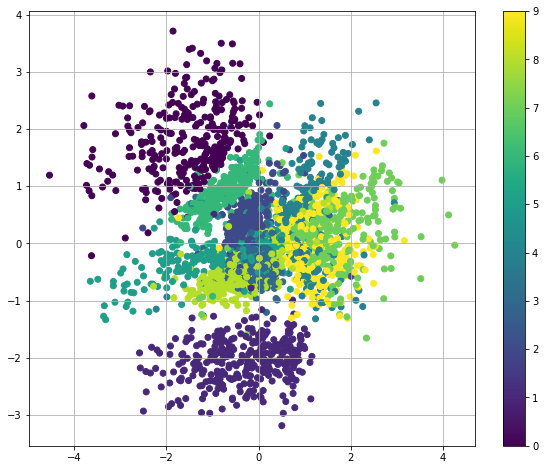

In [19]:
# Test the trained model: transformation
batch = mnist.test.next_batch(3000)
z = model_2d.transformer(batch[0])
plt.figure(figsize=(10, 8)) 
plt.scatter(z[:, 0], z[:, 1], c=np.argmax(batch[1], 1))
plt.colorbar()
plt.grid()

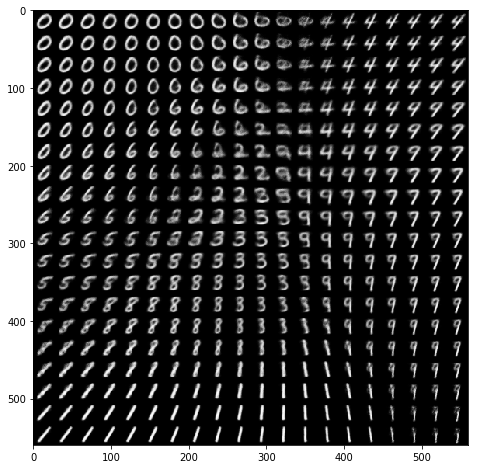

In [18]:
# Test the trained model: transformation
n = 20
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d.batch_size)
        x_hat = model_2d.generator(z)
        I_latent[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = x_hat[0].reshape(28, 28)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")

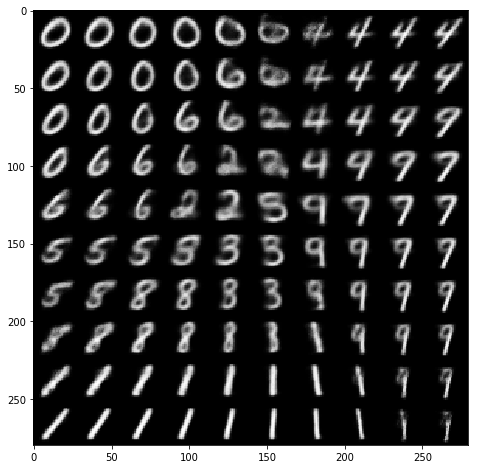

In [8]:
# Test the trained model: transformation
n = 10
x = np.linspace(-2, 2, n)
y = np.linspace(-2, 2, n)

I_latent = np.empty((h*n, w*n))
for i, yi in enumerate(x):
    for j, xi in enumerate(y):
        z = np.array([[xi, yi]]*model_2d.batch_size)
        x_hat = model_2d.generator(z)
        I_latent[(n-i-1)*28:(n-i)*28, j*28:(j+1)*28] = x_hat[0].reshape(28, 28)

plt.figure(figsize=(8, 8))        
plt.imshow(I_latent, cmap="gray")

In [20]:
digit_labels = np.argmax(batch[1], 1)

def same_digit_interpolation(n_cols = 9, z = z, digit_labels = digit_labels):
    same_digit = np.empty((10*28, n_cols*28))
    for d in range(10):
        d_ind = np.where(digit_labels == d)[0]
        (n0, n1) = np.random.choice(d_ind, 2)
        x0 = z[n0, 0]
        x1 = z[n1, 0]
        y0 = z[n0, 1]
        y1 = z[n1, 1]
        xs = np.linspace(x0, x1, n_cols)
        ys = np.linspace(y0, y1, n_cols)
        for j in range(len(xs)):
            x_hat = model_2d.generator(np.array([[xs[j], ys[j]]]*model_2d.batch_size))
            same_digit[d*28:(d+1)*28,j*28:(j+1)*28] = x_hat[0].reshape(28,28)
        
    plt.figure(figsize=(8, 8))
    plt.imshow(same_digit, cmap='gray')

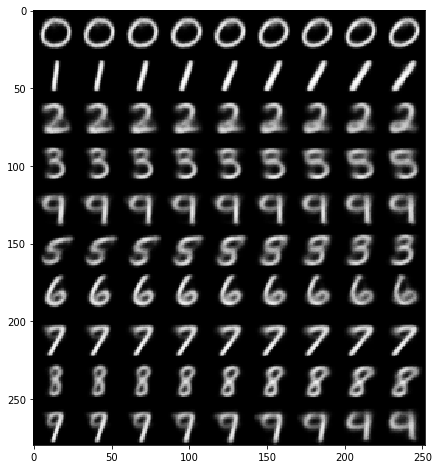

In [29]:
same_digit_interpolation()

In [30]:
digit_labels = np.argmax(batch[1], 1)

def diff_digit_interpolation(n_cols = 9, z = z, digit_labels = digit_labels):
    diff_digit = np.empty((10*28, n_cols*28))
    for d in range(10):
        d_ind0 = np.where(digit_labels == d)[0]
        if d < 9:
            d_ind1 = np.where(digit_labels == d+1)[0]
        else:
            d_ind1 = np.where(digit_labels == 0)[0]
        n0 = np.random.choice(d_ind0, 1)
        n1 = np.random.choice(d_ind1, 1)
        x0 = z[n0, 0]
        x1 = z[n1, 0]
        y0 = z[n0, 1]
        y1 = z[n1, 1]
        xs = np.linspace(x0, x1, n_cols)
        ys = np.linspace(y0, y1, n_cols)
        for j in range(len(xs)):
            x_hat = model_2d.generator(np.array([[xs[j], ys[j]]]*model_2d.batch_size))
            diff_digit[d*28:(d+1)*28,j*28:(j+1)*28] = x_hat[0].reshape(28,28)
        
    plt.figure(figsize=(8, 8))
    plt.imshow(diff_digit, cmap='gray')

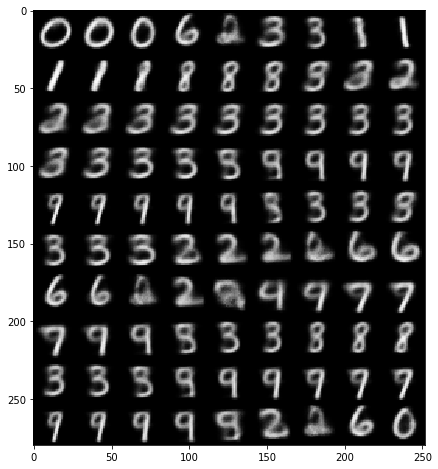

In [32]:
diff_digit_interpolation()